In [25]:
import torch
from torchvision.datasets import CIFAR10
from torch.utils.data import DataLoader
from torchvision.transforms import ToTensor

In [26]:
trainset = CIFAR10('/',download= True, train = True, transform=ToTensor())

In [27]:
trainset

Dataset CIFAR10
    Number of datapoints: 50000
    Root location: /
    Split: Train
    StandardTransform
Transform: ToTensor()

In [28]:
testset = CIFAR10('/',download= True, train = False, transform=ToTensor())

In [29]:
testset

Dataset CIFAR10
    Number of datapoints: 10000
    Root location: /
    Split: Test
    StandardTransform
Transform: ToTensor()

In [30]:
trainloader = DataLoader(trainset, batch_size= 128)
testloader = DataLoader(testset, batch_size= 128)

In [31]:
next(iter(trainloader))[0][5].shape

torch.Size([3, 32, 32])

In [32]:
import matplotlib.pyplot as plt
import numpy as np

torch.Size([128])


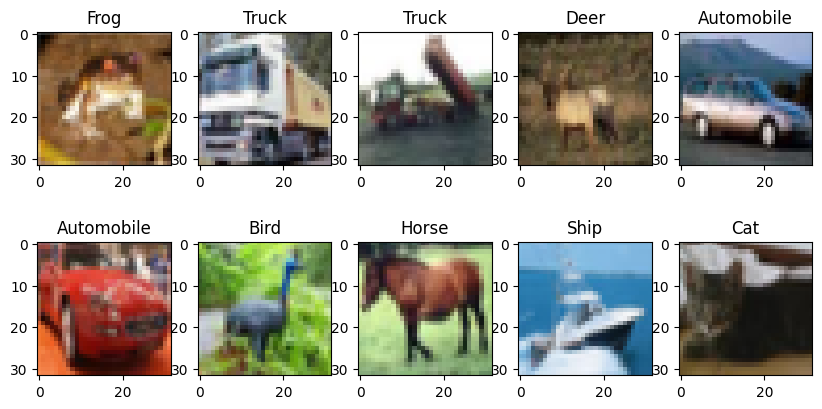

In [33]:
trainInterator = iter(trainloader)
images, labels = next(trainInterator)

classes = ['Airplane', 'Automobile', 'Bird', 'Cat', 'Deer',
               'Dog', 'Frog', 'Horse', 'Ship', 'Truck']

fig, axes = plt.subplots(2,5, figsize=(10,5))

print(labels.shape)
for i, ax in enumerate(axes.flat):
  # print(i)
  img = images[i]
  img = np.transpose(img.numpy(),(1,2,0))

  ax.imshow(img)
  ax.set_title(classes[labels[i]])


In [34]:
import torch.nn as nn

In [48]:
class CNNModel(nn.Module):
  def __init__(self):
    super(CNNModel, self).__init__()

    self.convlayer1 = nn.Conv2d(in_channels=3, out_channels= 16, kernel_size = 3,padding = 1)
    self.convlayer2 = nn.Conv2d(in_channels=16, out_channels= 32, kernel_size = 3,padding = 1)
    self.convlayer3 = nn.Conv2d(in_channels=32, out_channels= 64, kernel_size = 3,padding = 1)

    self.relu = nn.ReLU()

    self.maxpool = nn.MaxPool2d(kernel_size = 2, stride = 2)

    self.linear1 = nn.Linear(64*4*4,128)

    self.linear2 = nn.Linear(128,10)


  def forward(self, X):
    result1 = self.maxpool(self.relu(self.convlayer1(X)))
    result2 = self.maxpool(self.relu(self.convlayer2(result1)))
    result3 = self.maxpool(self.relu(self.convlayer3(result2)))

    result4 = result3.view(-1,64*4*4)

    result5 = self.relu(self.linear1(result4))

    result6 = self.linear2(result5)

    return result6

In [92]:
def train_one_epoch(model, dataloader, loss_func, optimizer, device):
  model.train()

  total_loss = 0
  correct_labled = 0
  total = 0

  for images, labels in dataloader:
    images = images.to(device)
    labels = labels.to(device)

    outputs = model(images)

    loss = loss_func(outputs, labels)

    optimizer.zero_grad()

    loss.backward()

    optimizer.step()

    total_loss += loss.item()

    probabilties = torch.softmax(outputs, dim=1)
    perdictions = torch.argmax(probabilties, dim=1)
   # print(perdictions.shape)
    #print(labels.shape)
    correct_labled += (perdictions==labels).sum().item()

    total += labels.size(0)

  average_loss = total_loss/ len(dataloader)


  accuarcy = 100* correct_labled/total

  return average_loss, accuarcy

In [93]:
def validate_one_epoch(model, dataloader, loss_func, device):
  model.eval()

  total_loss = 0
  correct_labled = 0
  total = 0

  with torch.no_grad():
    for images, labels in dataloader:
      images = images.to(device)
      labels = labels.to(device)

      outputs = model(images)

      loss = loss_func(outputs, labels)

      total_loss += loss.item()
      probabilties = torch.softmax(outputs, dim=1)
      perdictions = torch.argmax(probabilties, dim=1)
      correct_labled += (perdictions==labels).sum().item()
      total += labels.size(0)

  average_loss = total_loss/ len(dataloader)


  accuarcy = 100* correct_labled/total

  return average_loss, accuarcy

In [94]:
from tqdm import tqdm

In [95]:
import torch.optim as optim

In [96]:
torch.cuda.is_available()

True

In [97]:
device = "cuda:0"

In [98]:
model =CNNModel().to(device)

In [99]:
model

CNNModel(
  (convlayer1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (convlayer2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (convlayer3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu): ReLU()
  (maxpool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (linear1): Linear(in_features=1024, out_features=128, bias=True)
  (linear2): Linear(in_features=128, out_features=10, bias=True)
)

In [100]:
loss_function = nn.CrossEntropyLoss()

optimzer = optim.Adam(model.parameters(), lr = 0.001)

In [103]:
num_epochs = 6

loss_train = []
loss_test = []
acc_train = []
acc_test = []
#train_one_epoch(model, dataloader, loss_func, optimizer, device):
for epoch in range(num_epochs):
  train_loss_curr, train_acc_curr = train_one_epoch(model,trainloader,loss_function,optimzer,device)
  test_loss_curr, test_acc_curr = validate_one_epoch(model,testloader,loss_function,device)


  loss_train.append(train_loss_curr)
  loss_test.append(test_loss_curr)

  acc_train.append(train_acc_curr)
  acc_test.append(test_acc_curr)


  print(f"Epoch {epoch+1}/{num_epochs}: "
          f"Train Loss={train_loss_curr:.4f}, Train Accuracy={train_acc_curr:.2f}%, "
          f"Val Loss={test_loss_curr:.4f}, Val Accuracy={test_acc_curr:.2f}%")



Epoch 1/6: Train Loss=1.0121, Train Accuracy=64.20%, Val Loss=1.0084, Val Accuracy=64.36%
Epoch 2/6: Train Loss=0.9386, Train Accuracy=66.86%, Val Loss=0.9555, Val Accuracy=66.52%
Epoch 3/6: Train Loss=0.8809, Train Accuracy=68.94%, Val Loss=0.9274, Val Accuracy=67.36%
Epoch 4/6: Train Loss=0.8383, Train Accuracy=70.63%, Val Loss=0.8966, Val Accuracy=68.63%
Epoch 5/6: Train Loss=0.8003, Train Accuracy=72.01%, Val Loss=0.8816, Val Accuracy=69.39%
Epoch 6/6: Train Loss=0.7671, Train Accuracy=73.12%, Val Loss=0.8793, Val Accuracy=69.82%


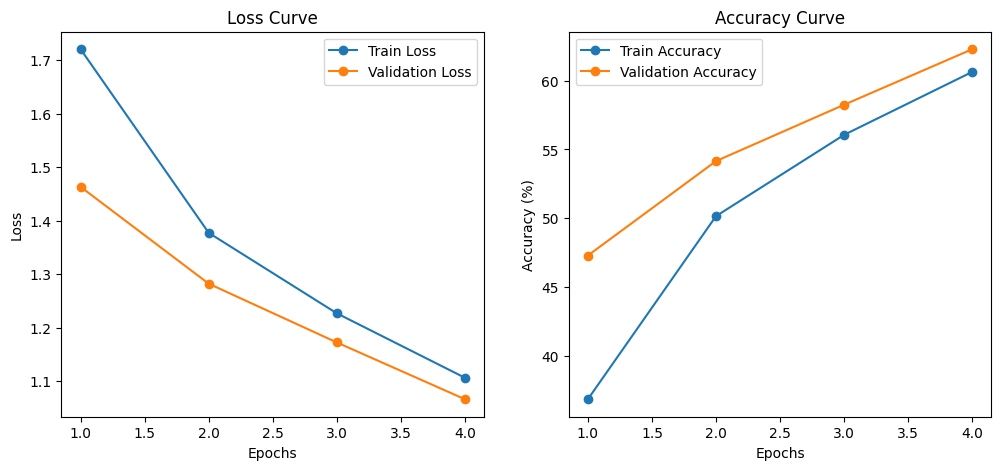

In [102]:
import matplotlib.pyplot as plt

# Plot loss curve
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(range(1, num_epochs+1), loss_train, label="Train Loss", marker='o')
plt.plot(range(1, num_epochs+1), loss_test, label="Validation Loss", marker='o')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Loss Curve")
plt.legend()

# Plot accuracy curve
plt.subplot(1, 2, 2)
plt.plot(range(1, num_epochs+1), acc_train, label="Train Accuracy", marker='o')
plt.plot(range(1, num_epochs+1), acc_test, label="Validation Accuracy", marker='o')
plt.xlabel("Epochs")
plt.ylabel("Accuracy (%)")
plt.title("Accuracy Curve")
plt.legend()

plt.show()


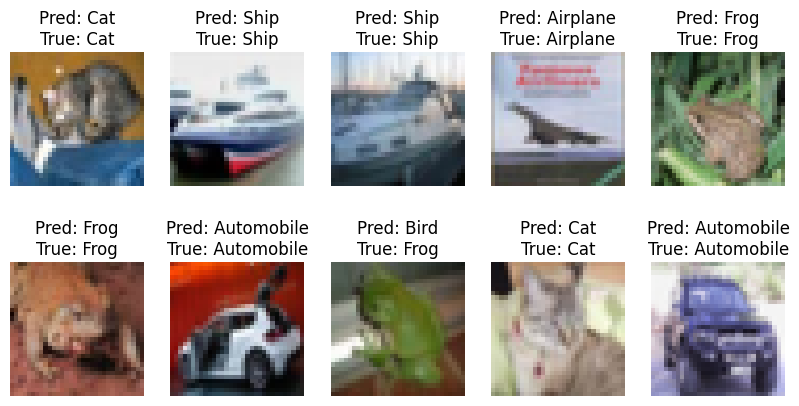

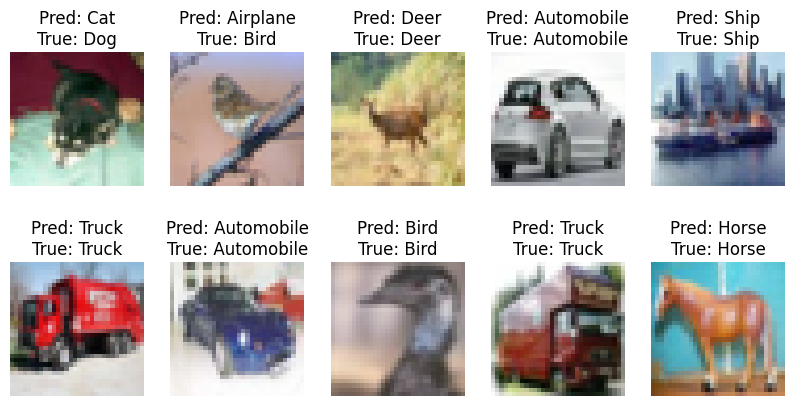

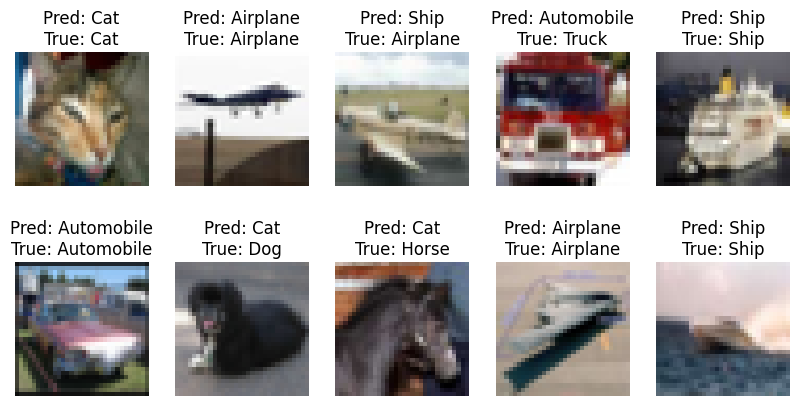

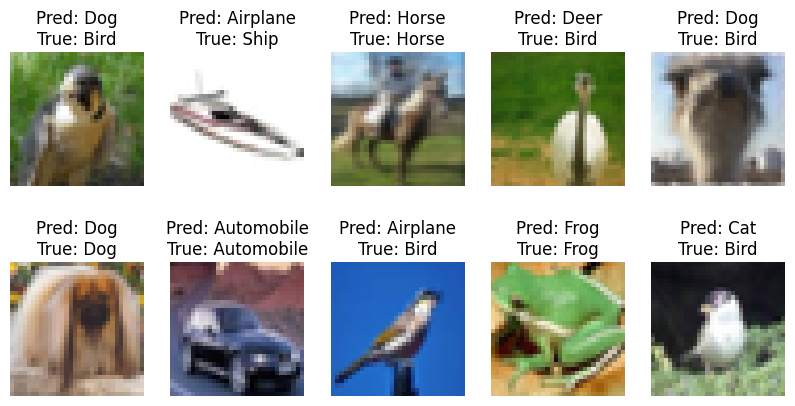

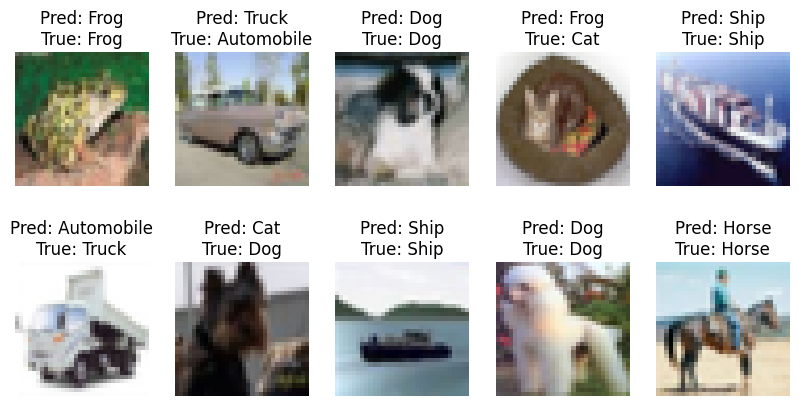

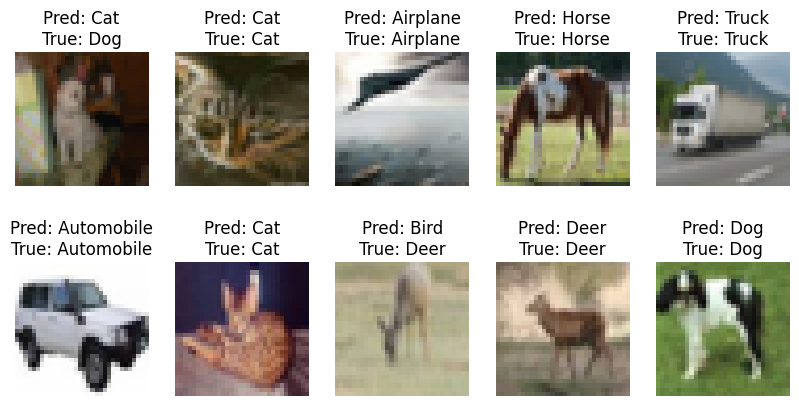

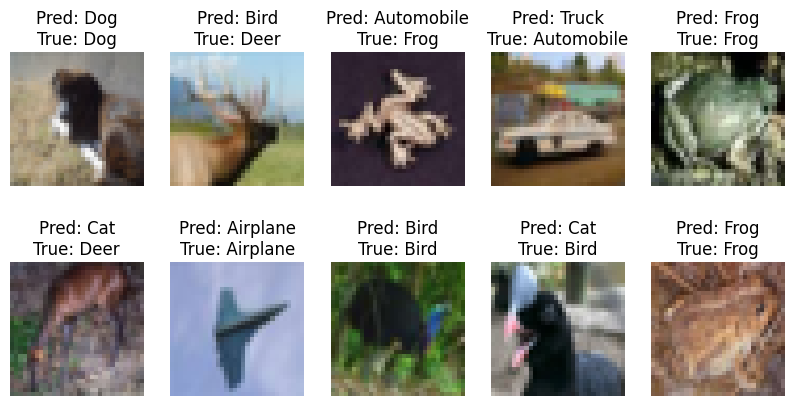

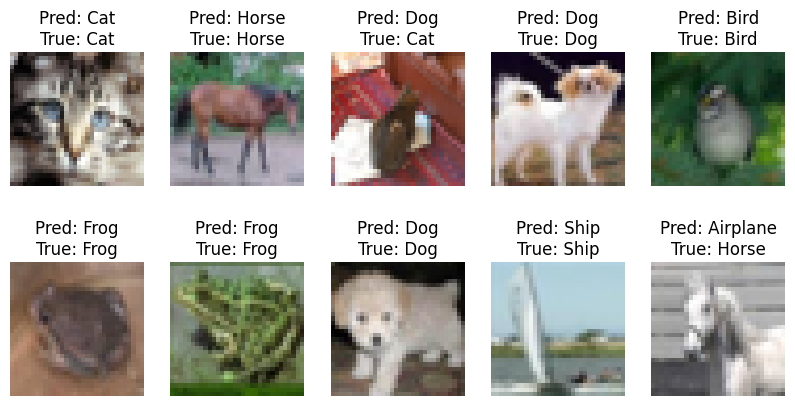

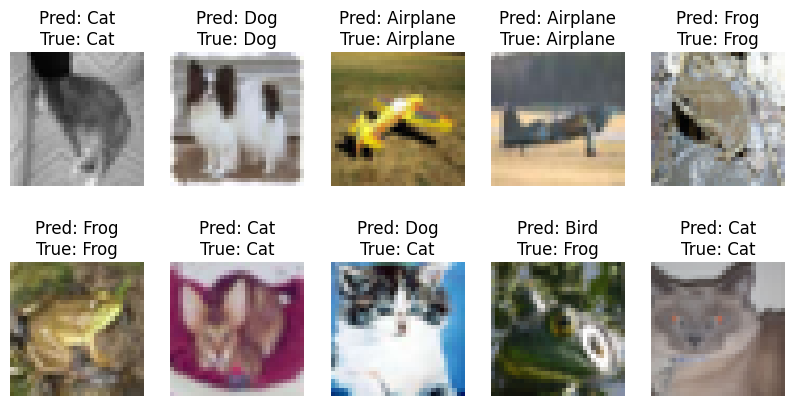

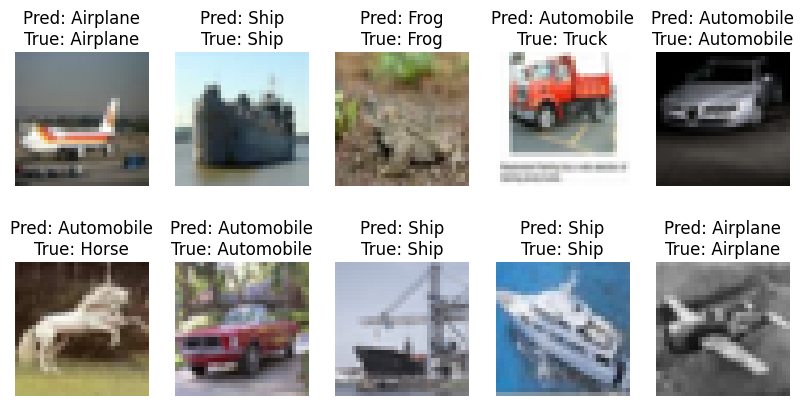

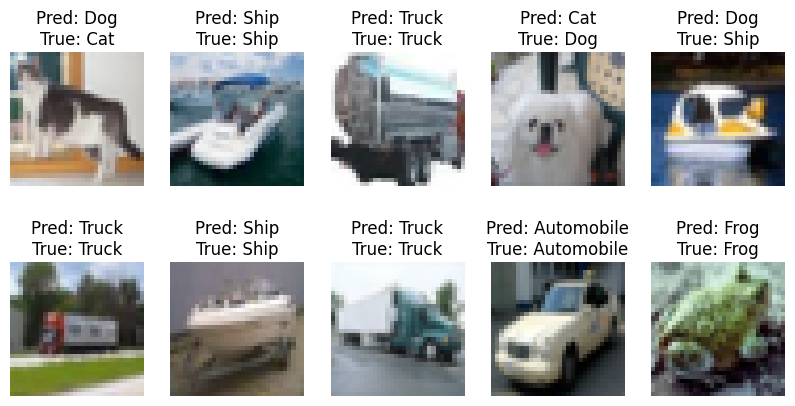

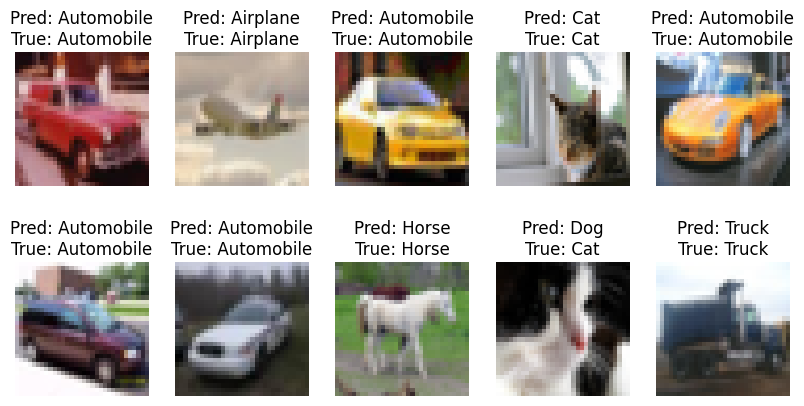

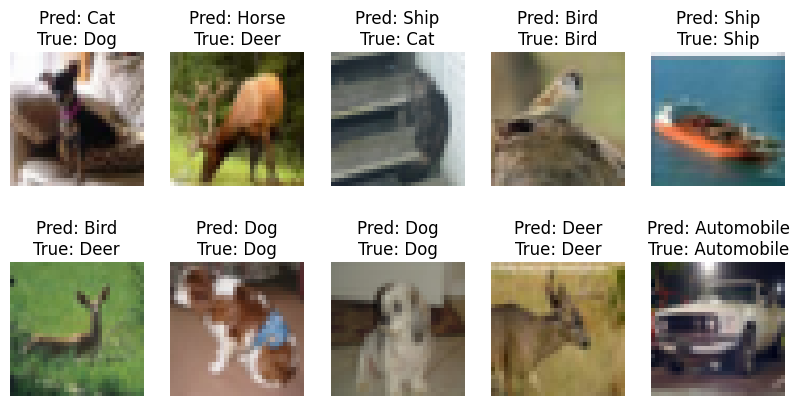

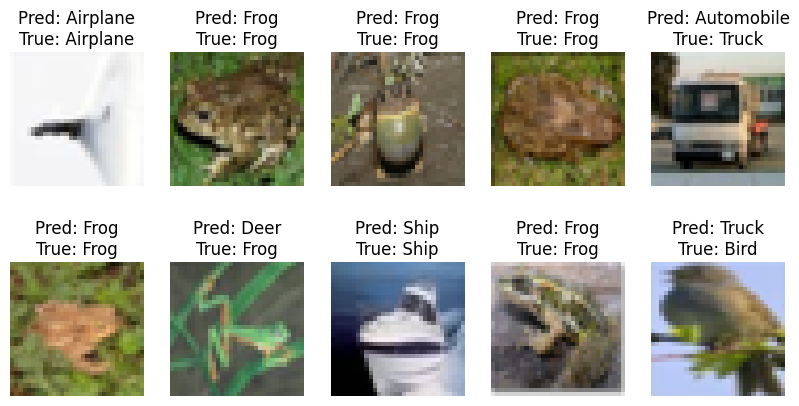

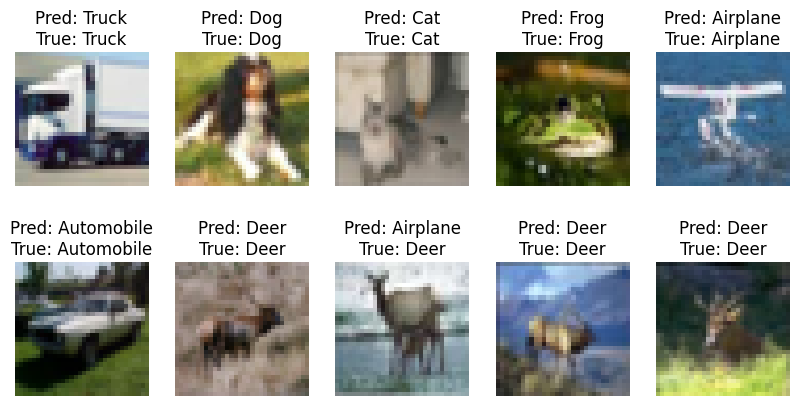

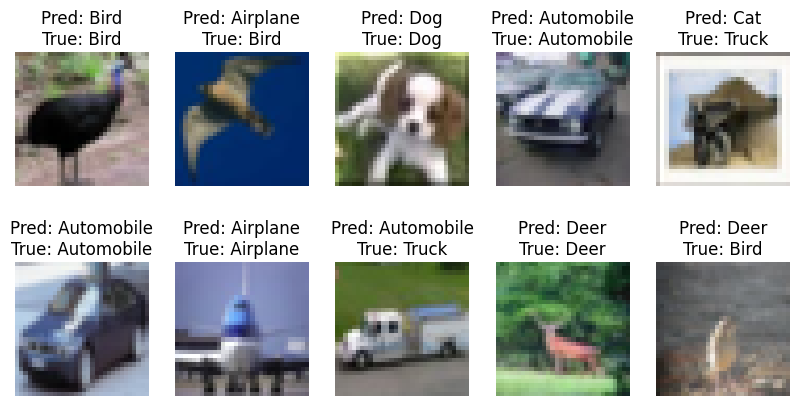

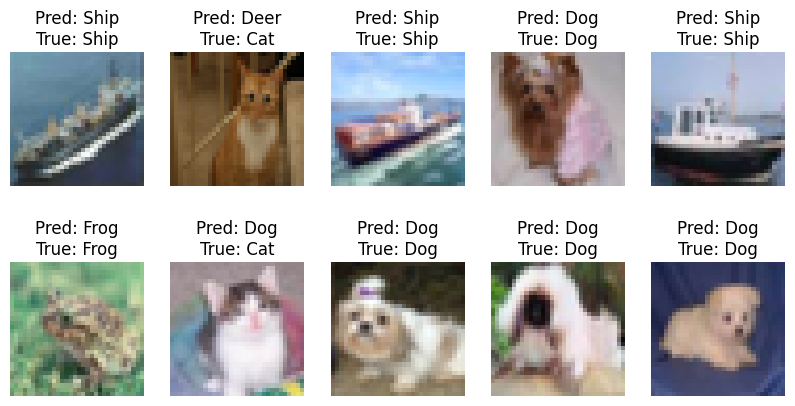

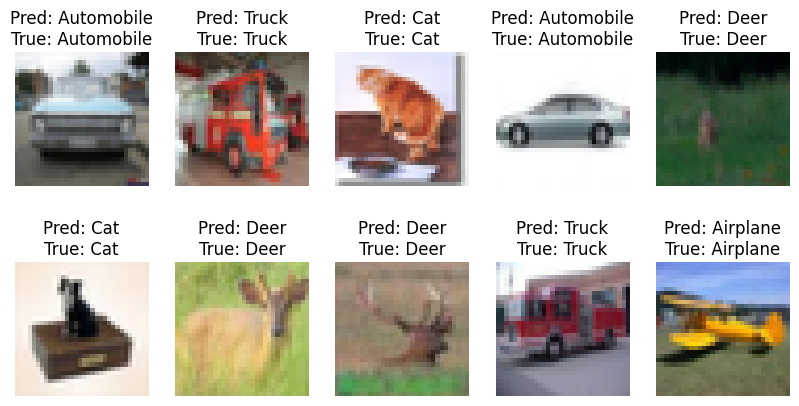

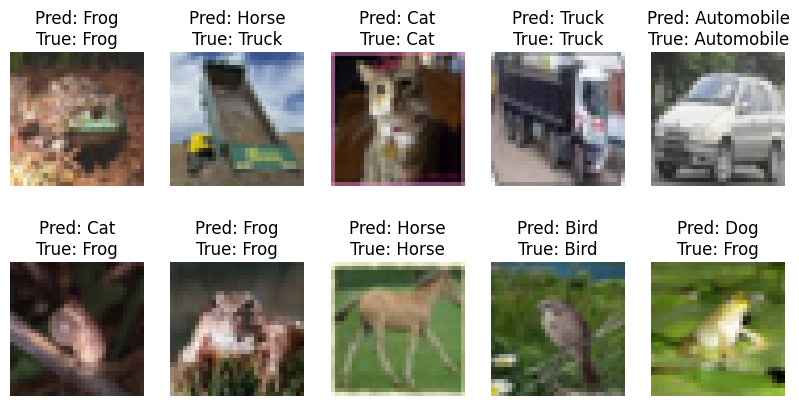

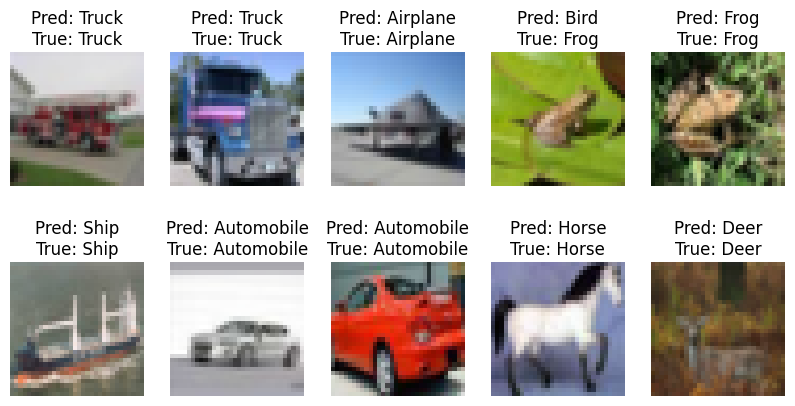

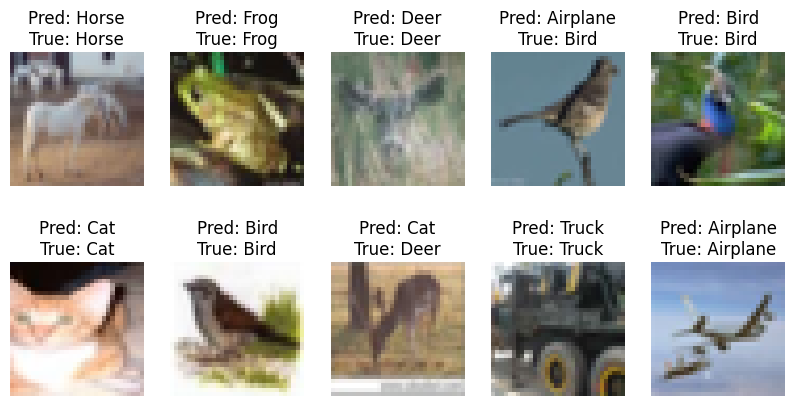

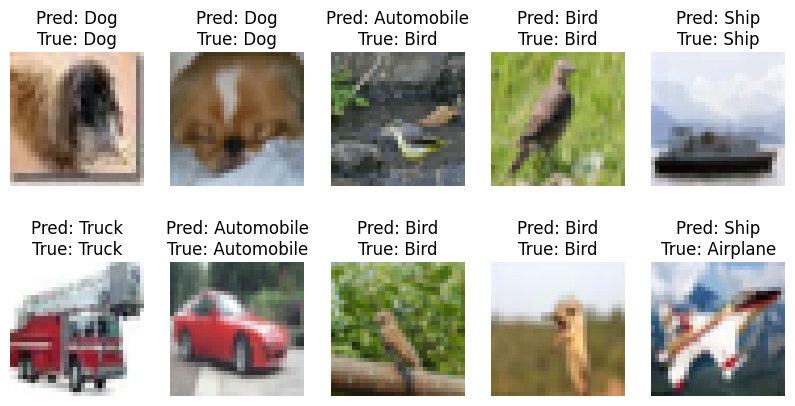

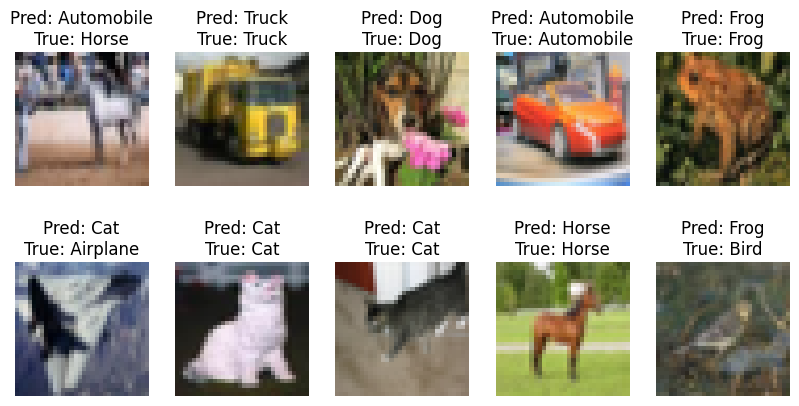

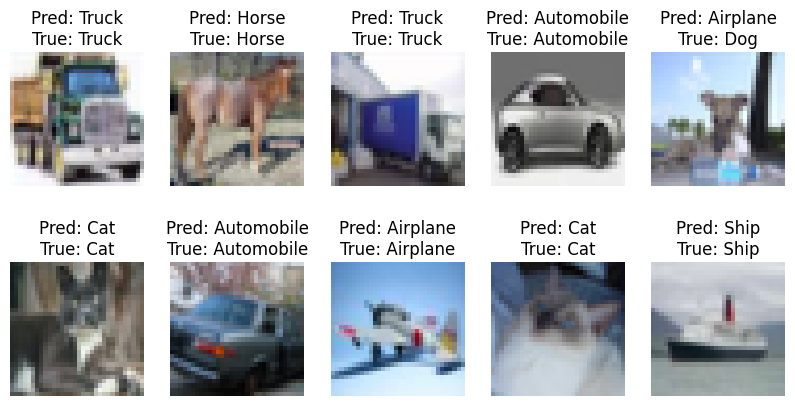

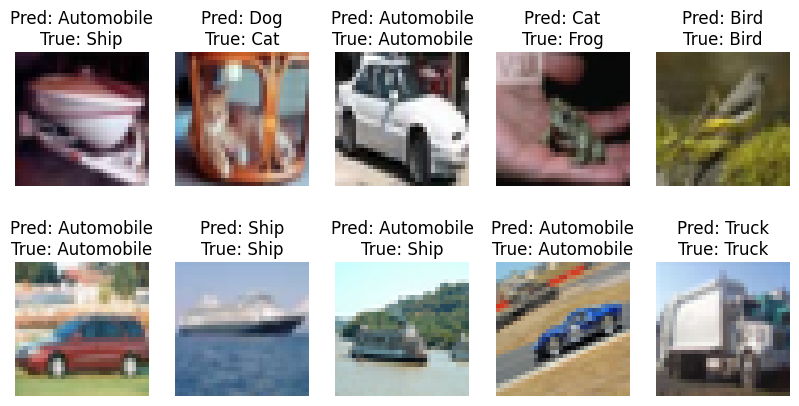

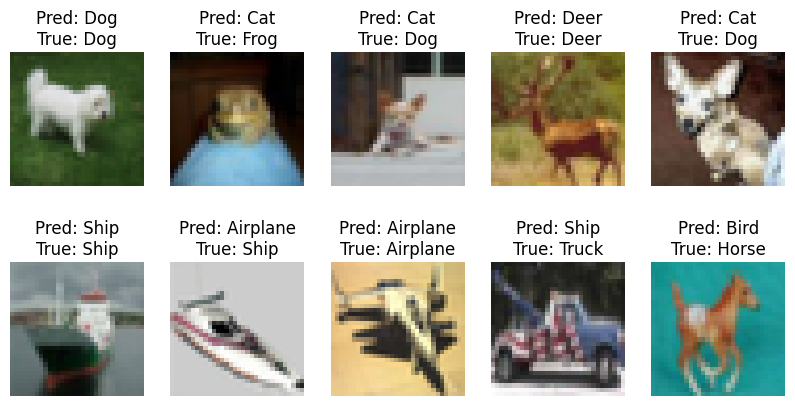

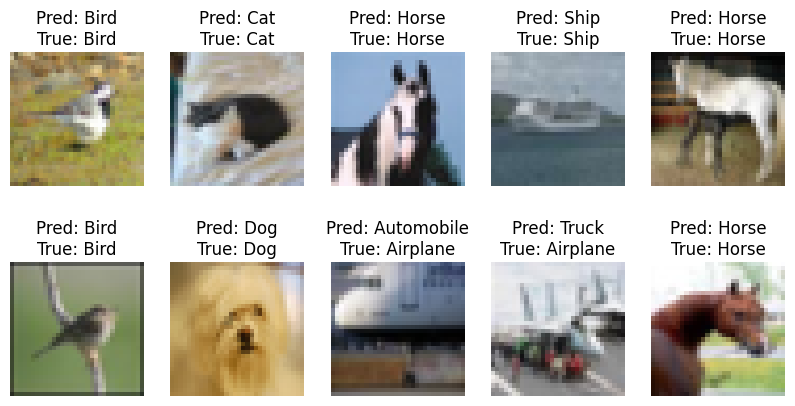

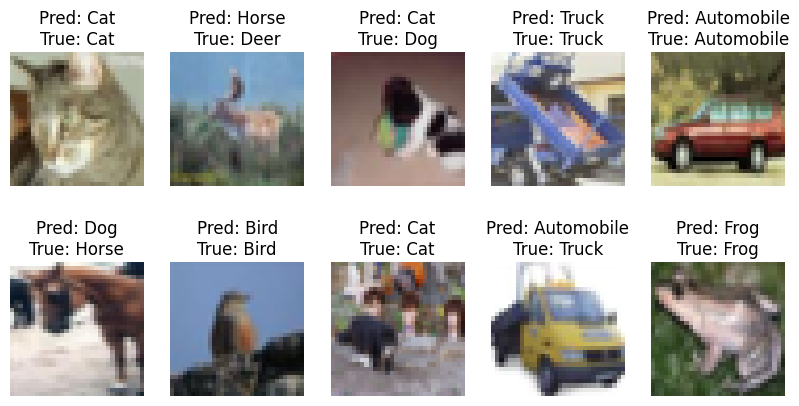

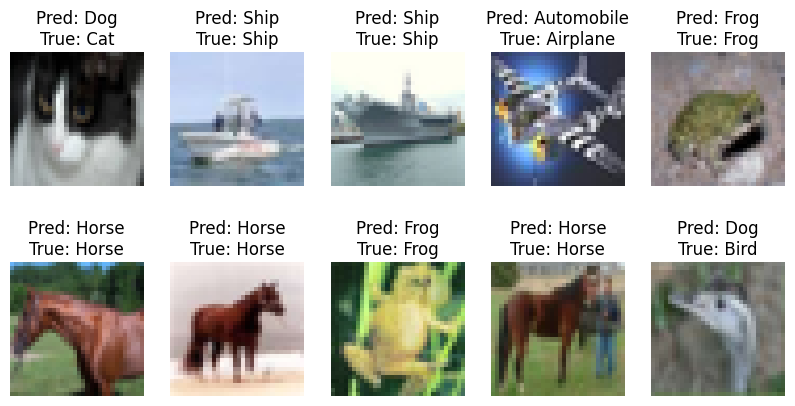

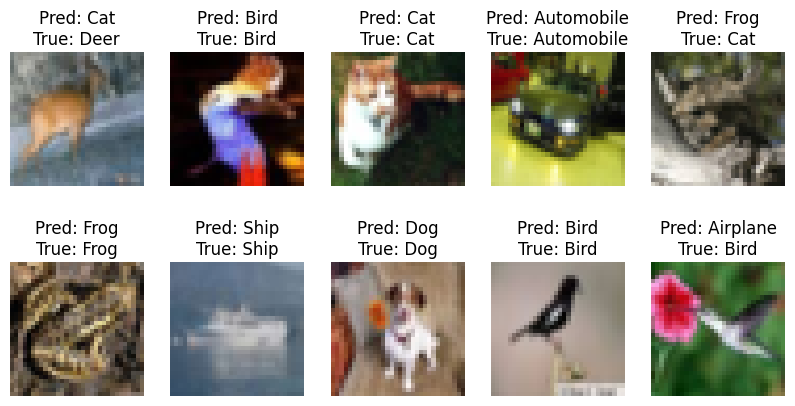

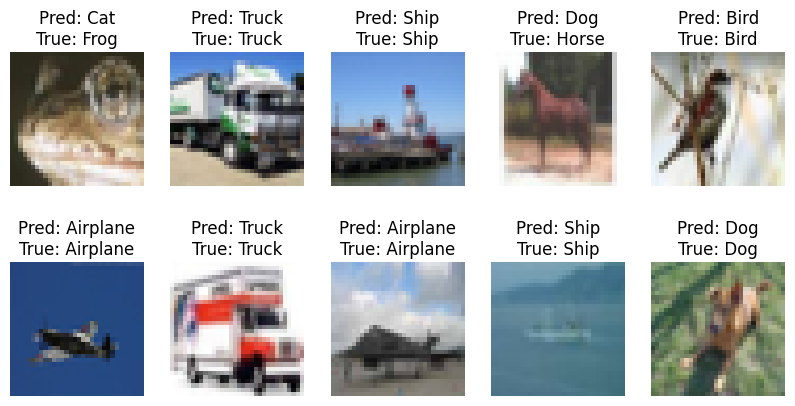

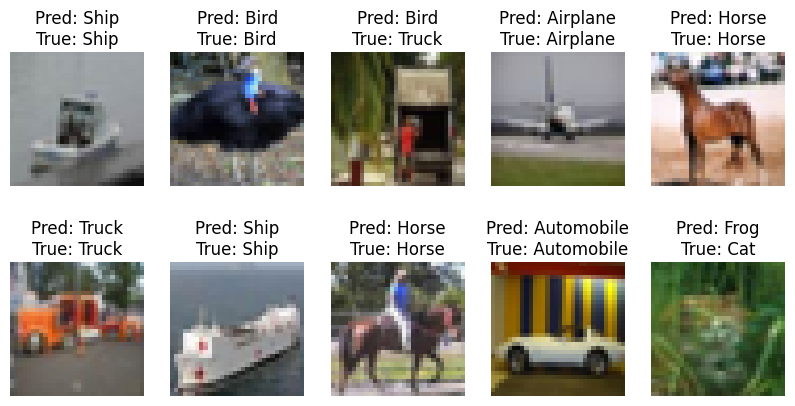

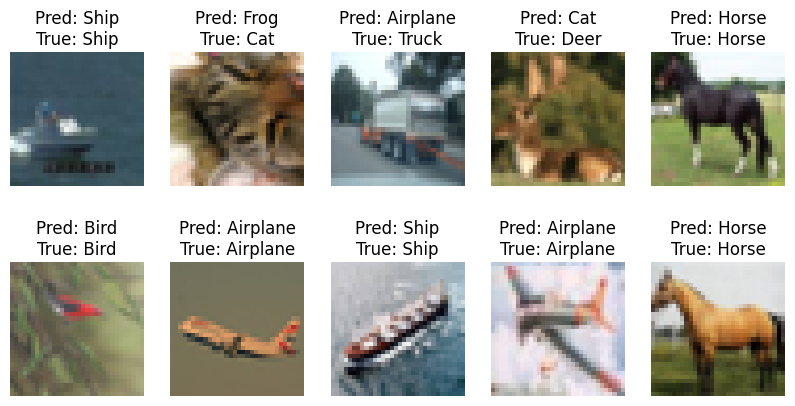

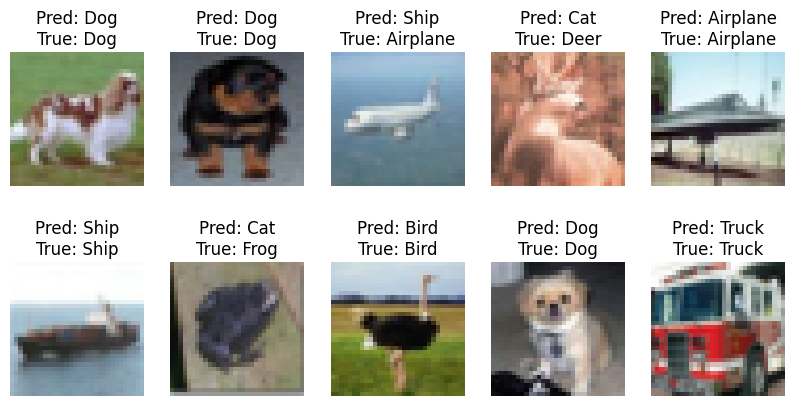

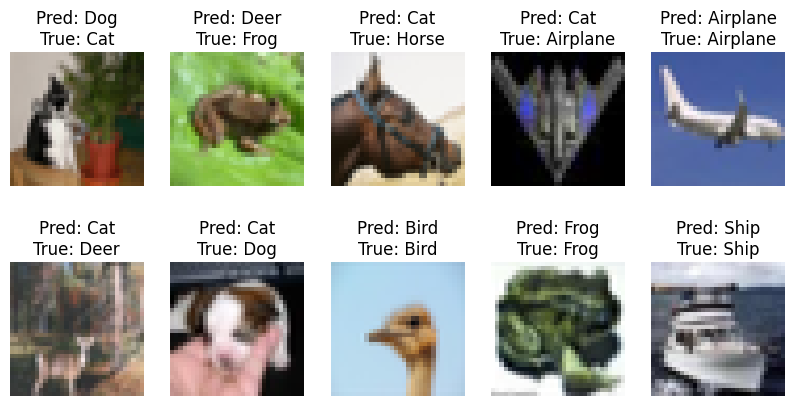

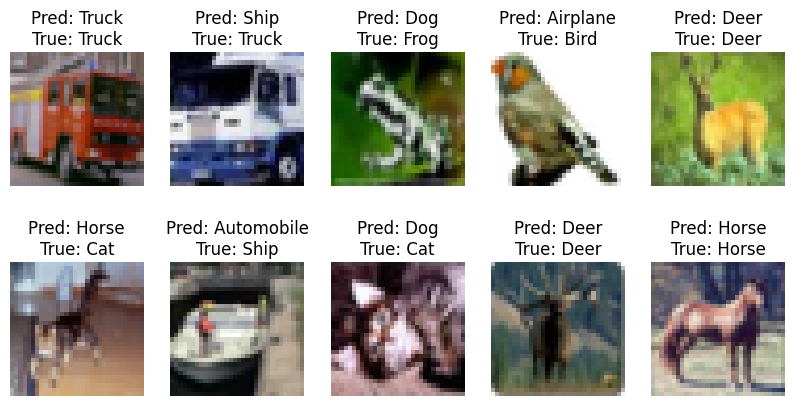

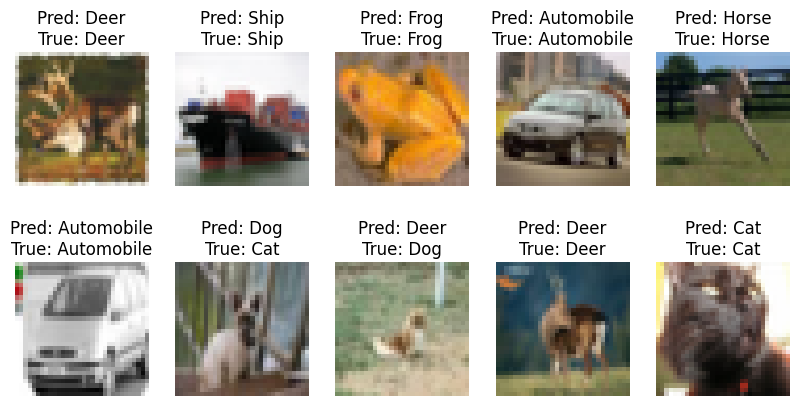

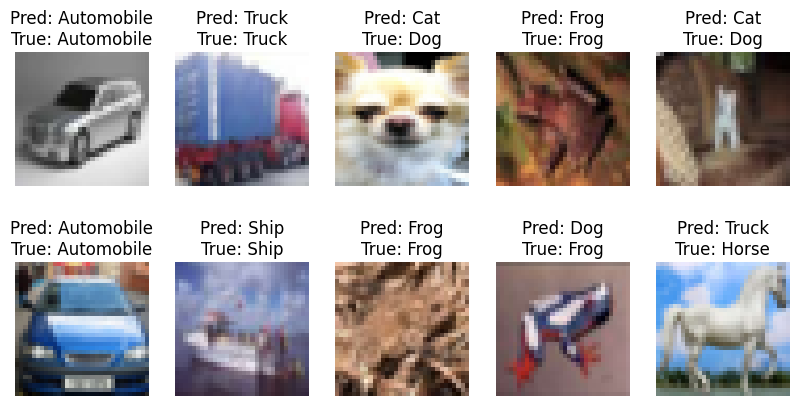

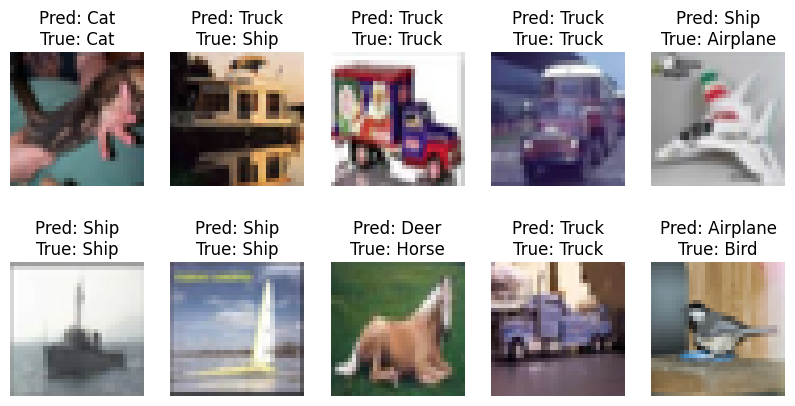

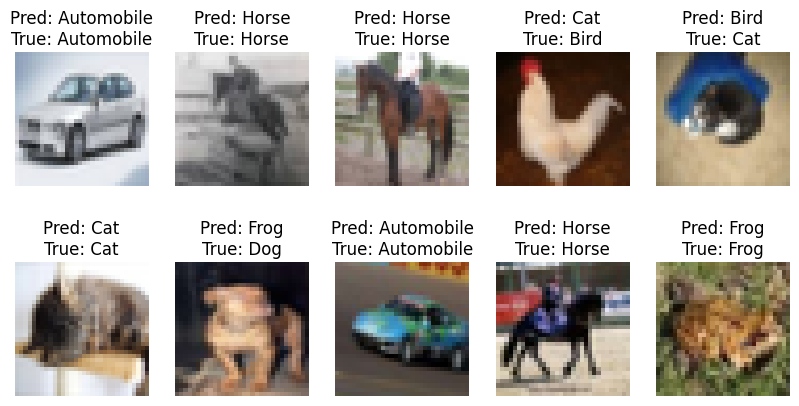

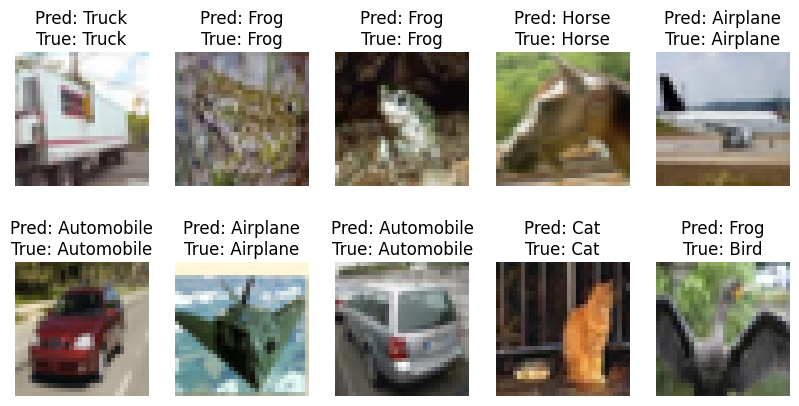

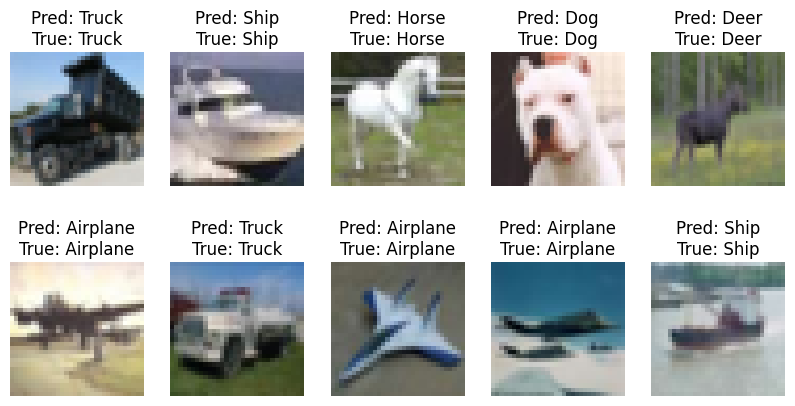

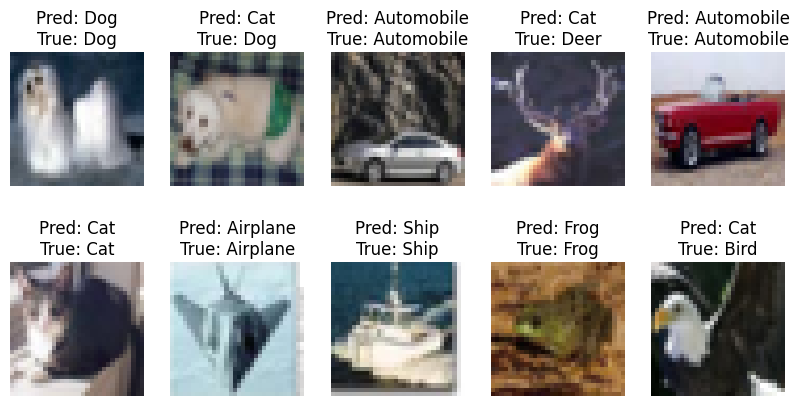

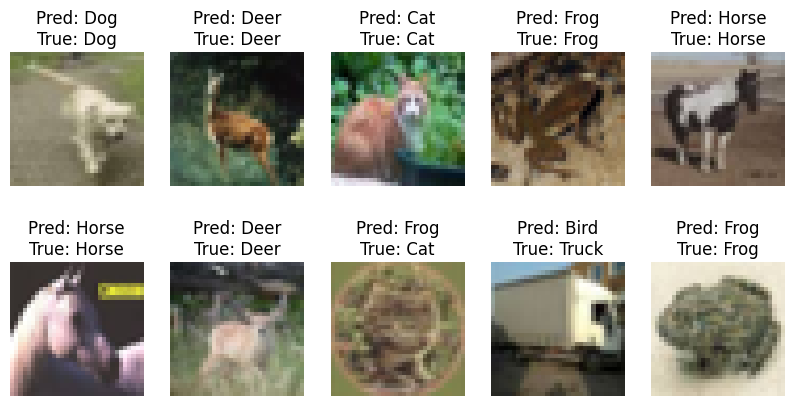

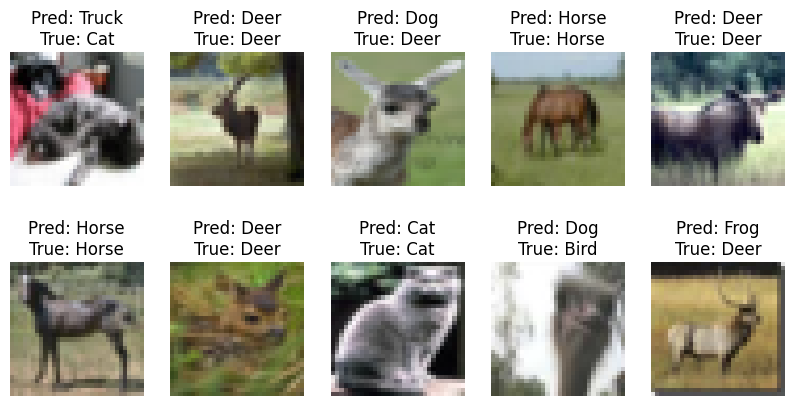

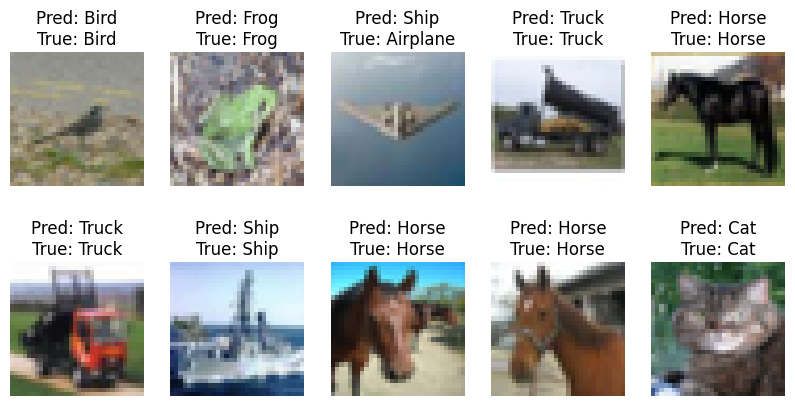

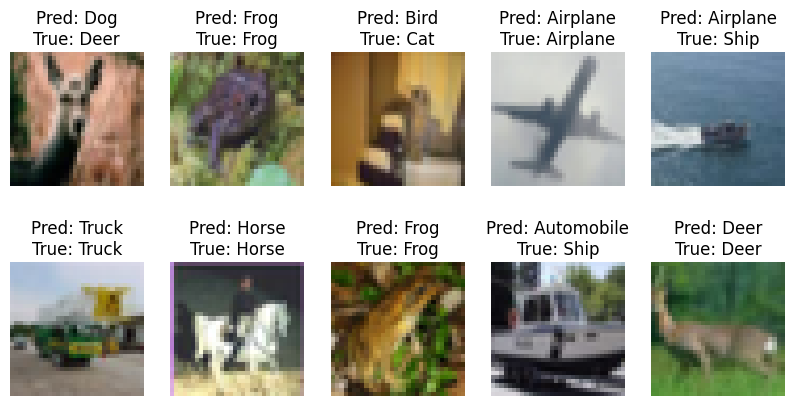

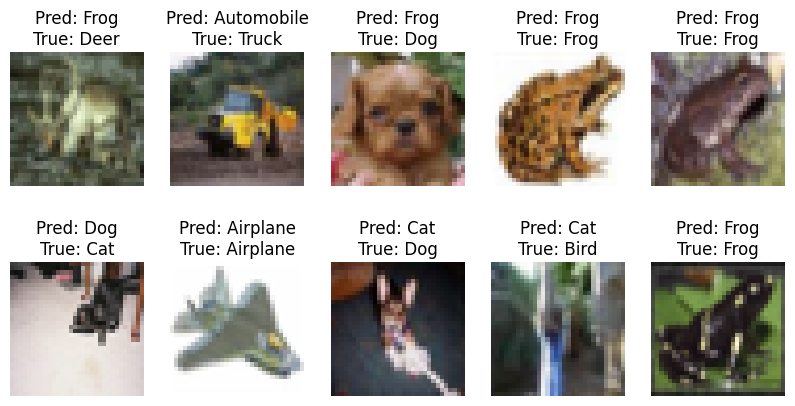

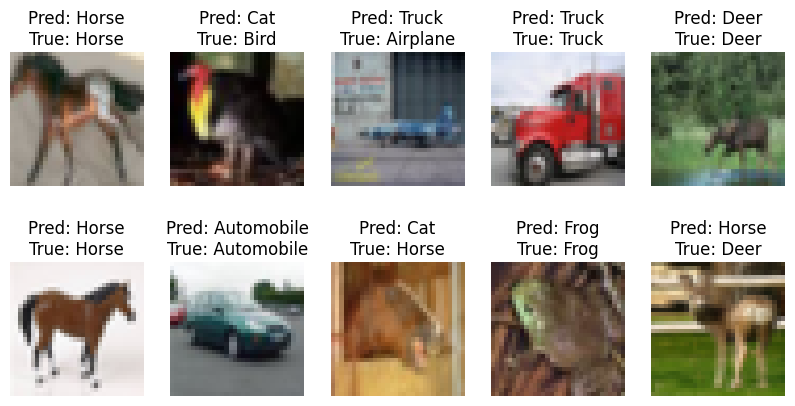

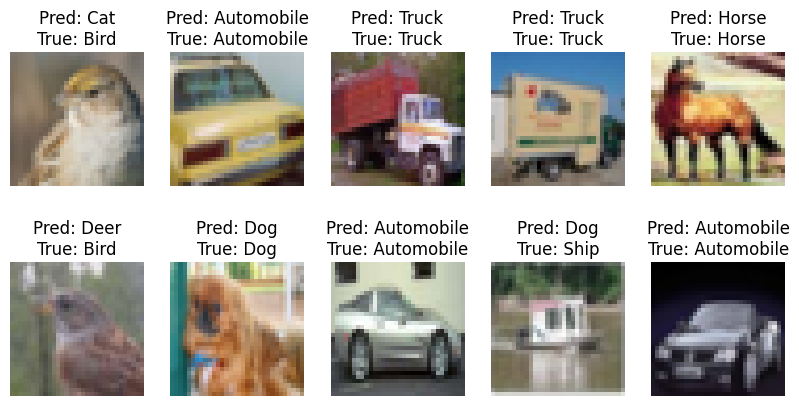

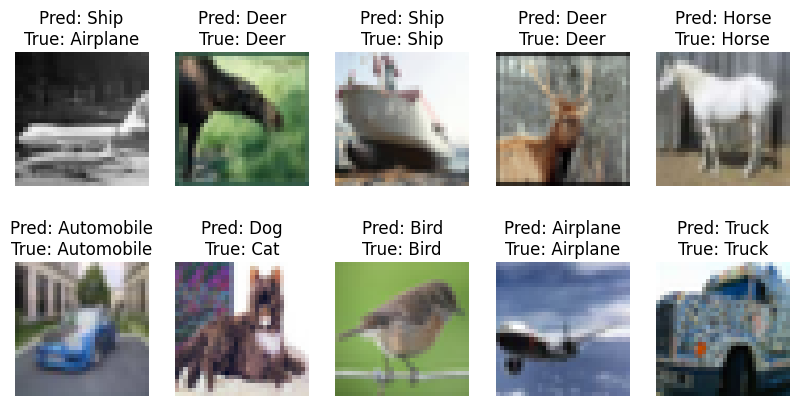

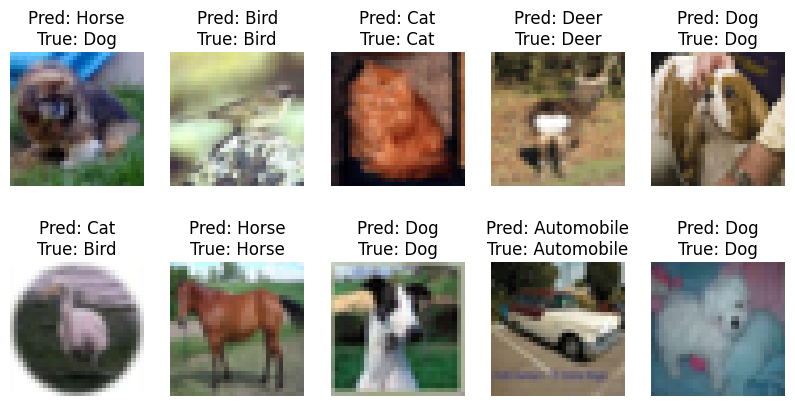

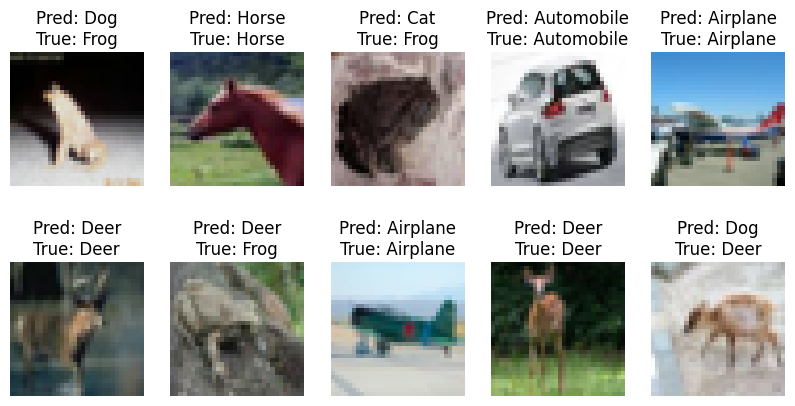

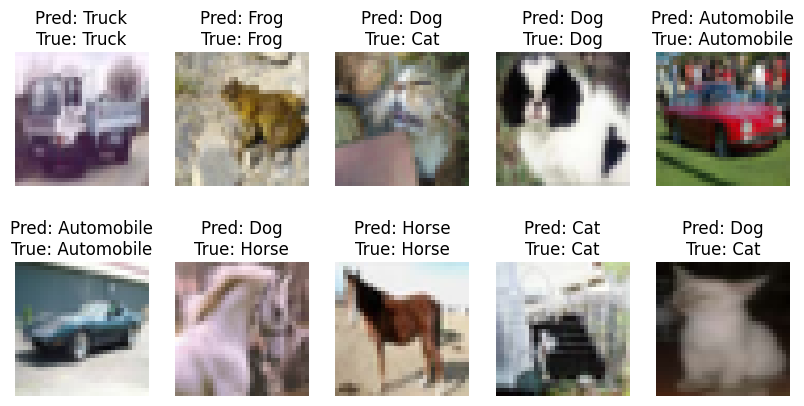

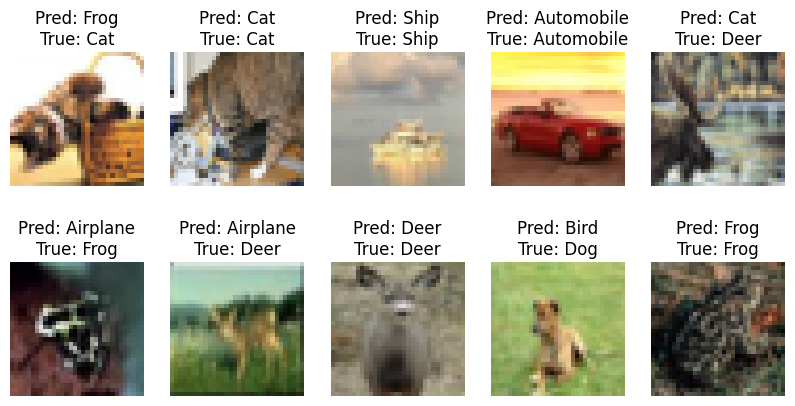

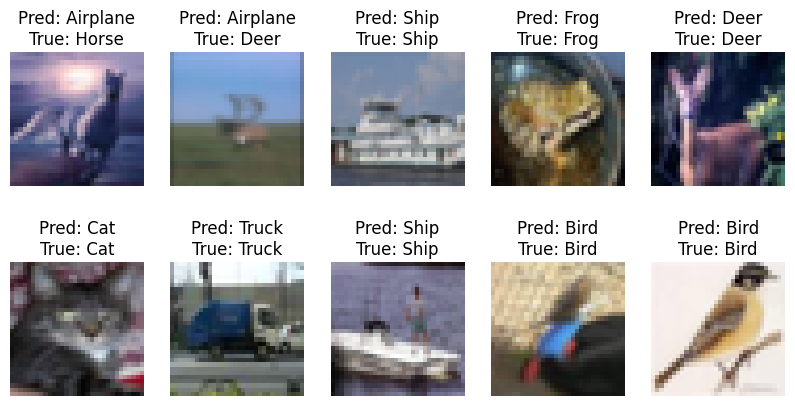

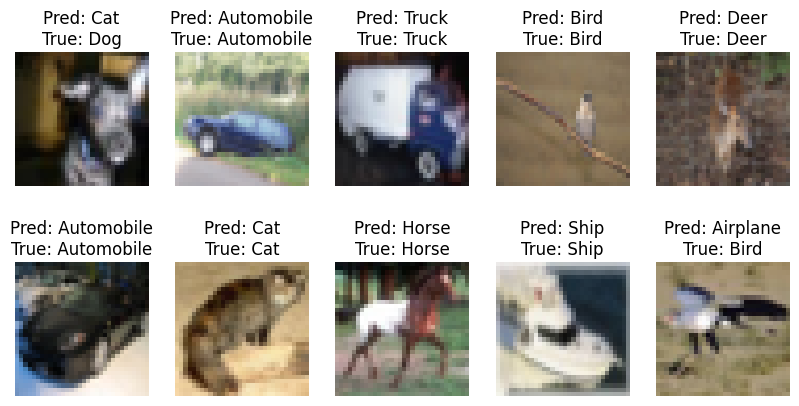

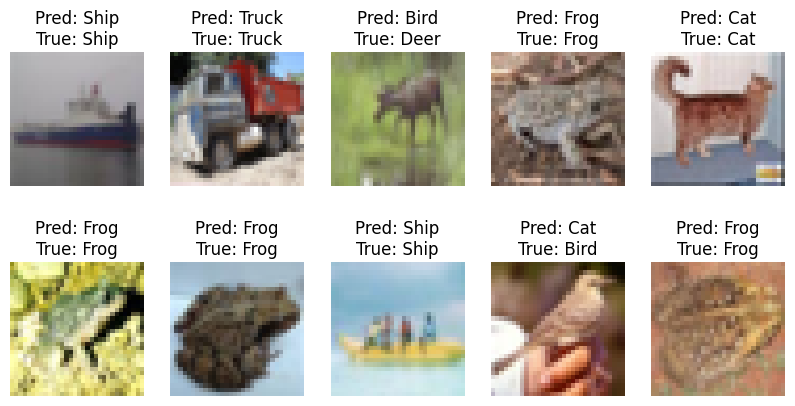

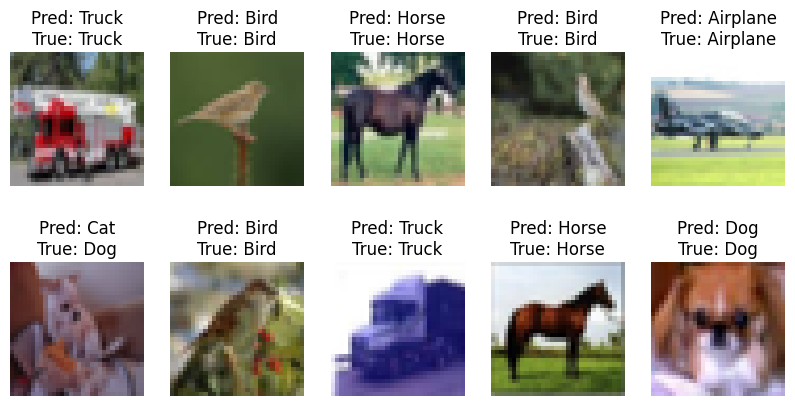

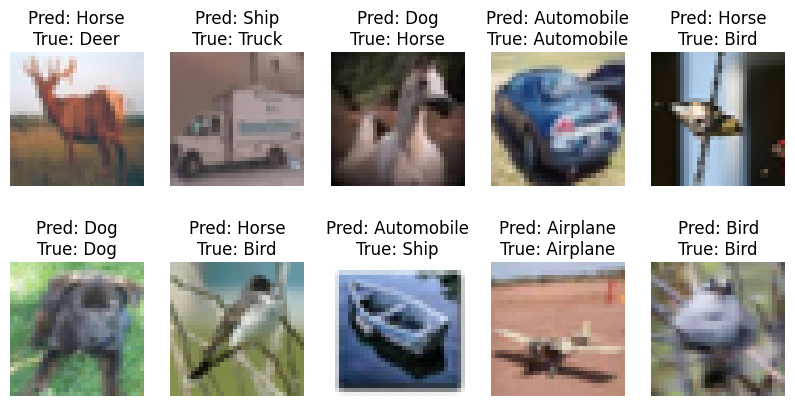

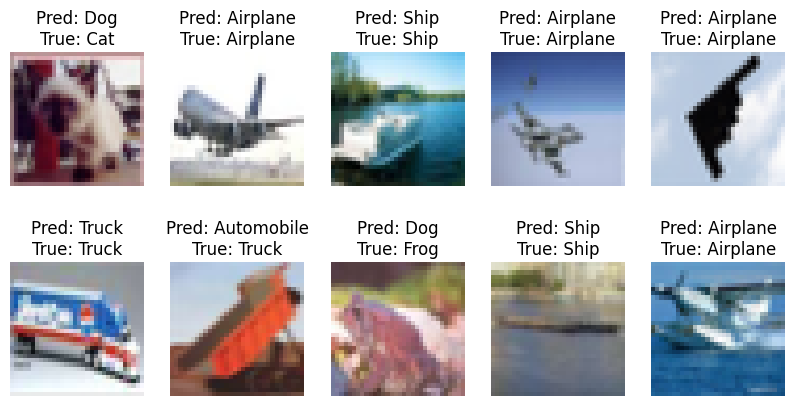

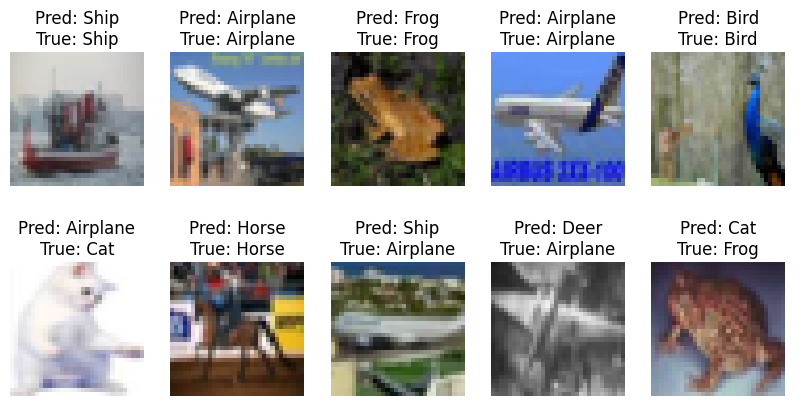

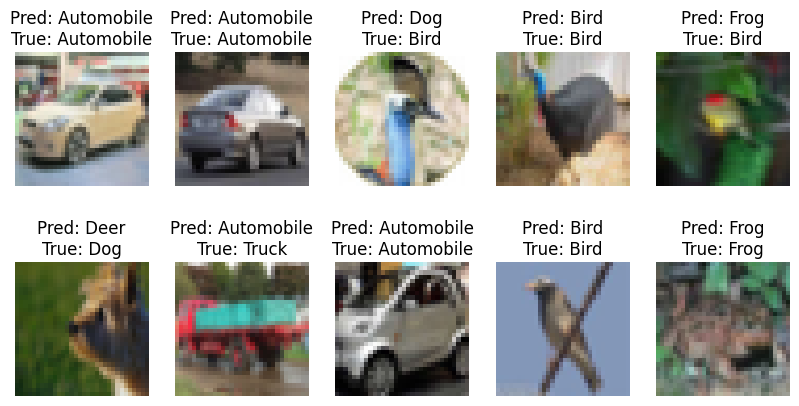

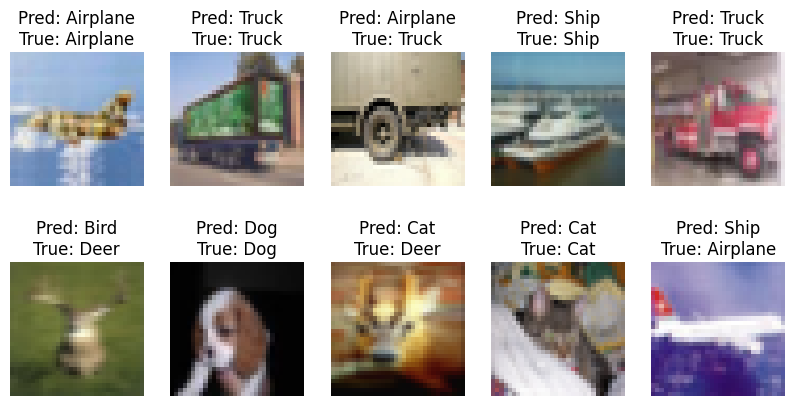

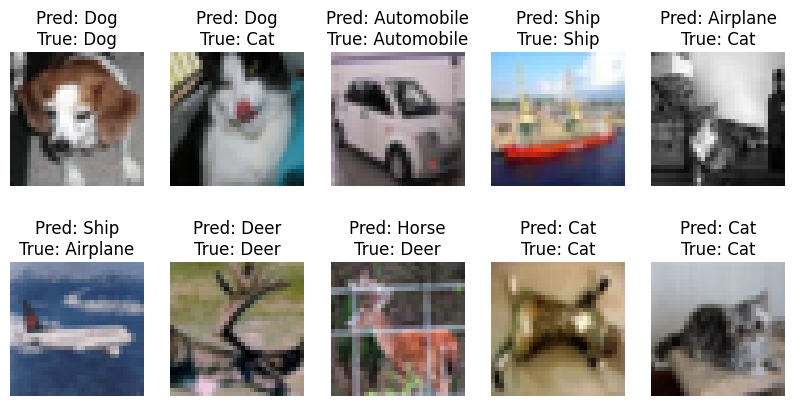

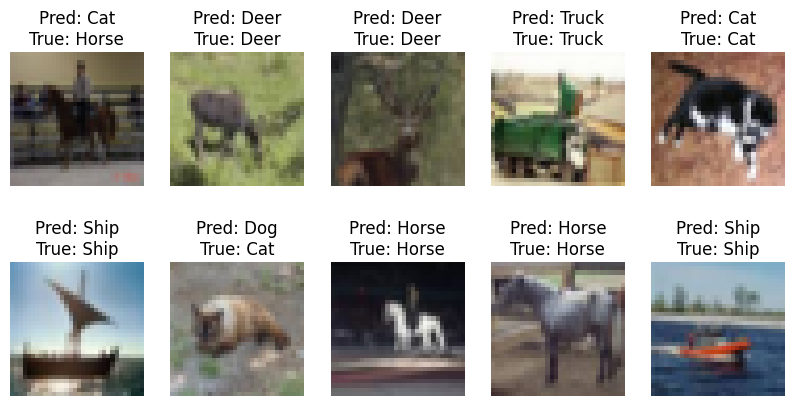

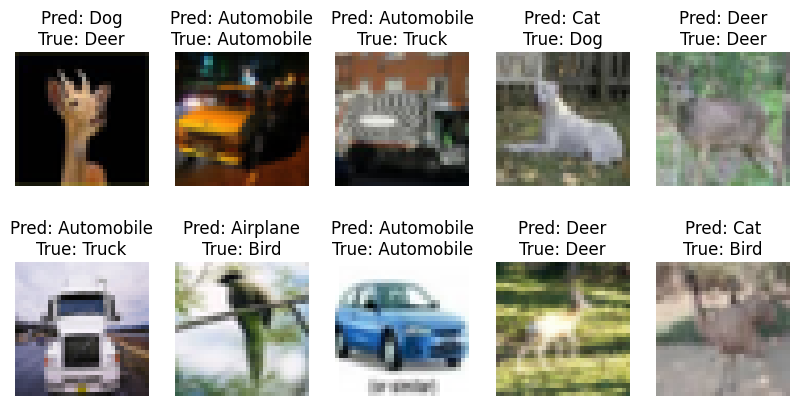

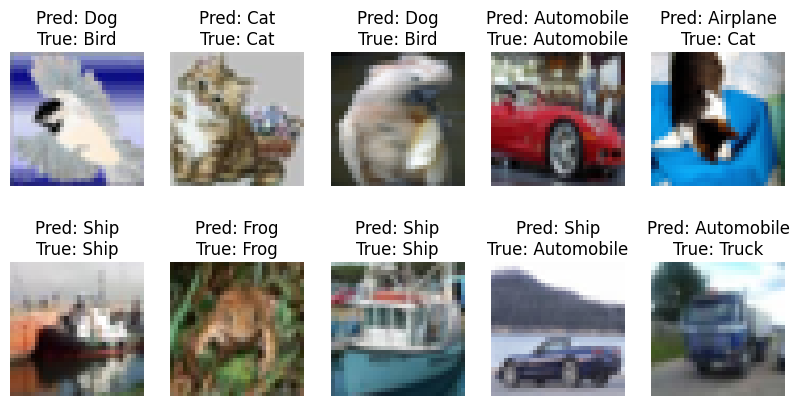

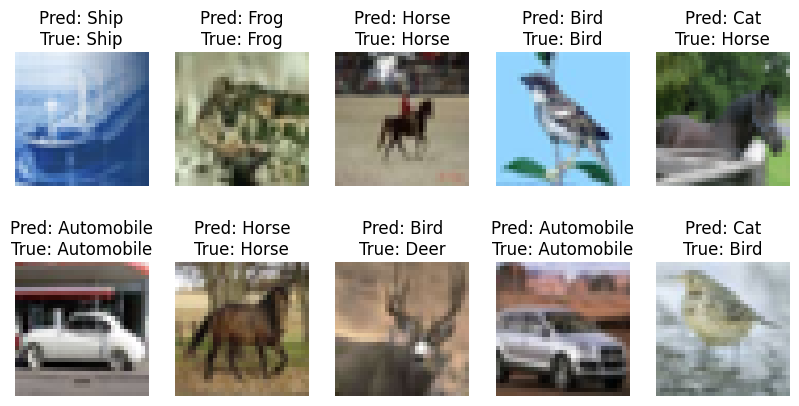

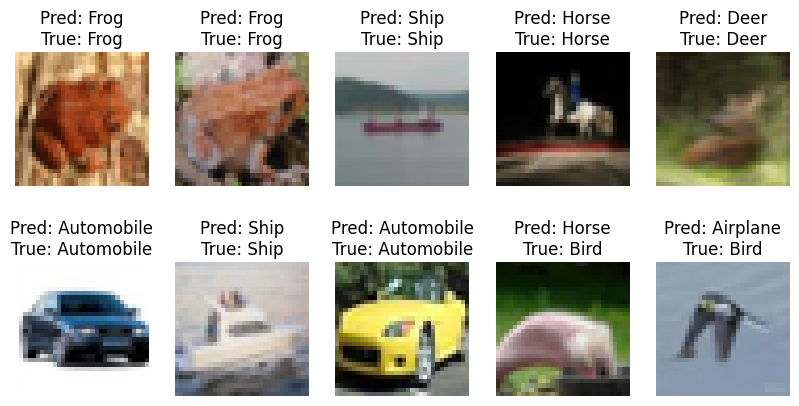

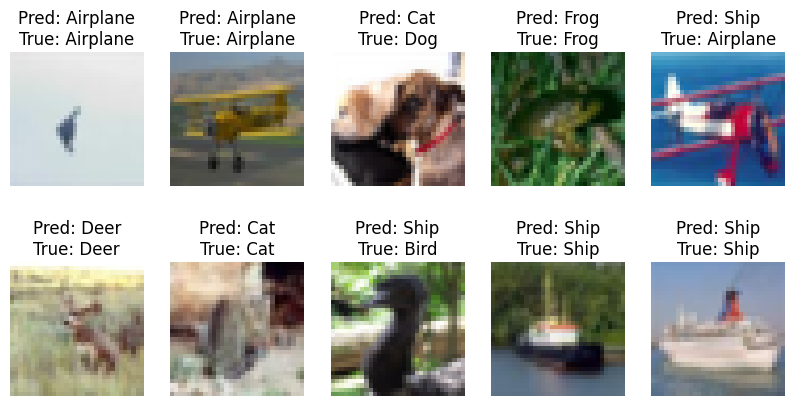

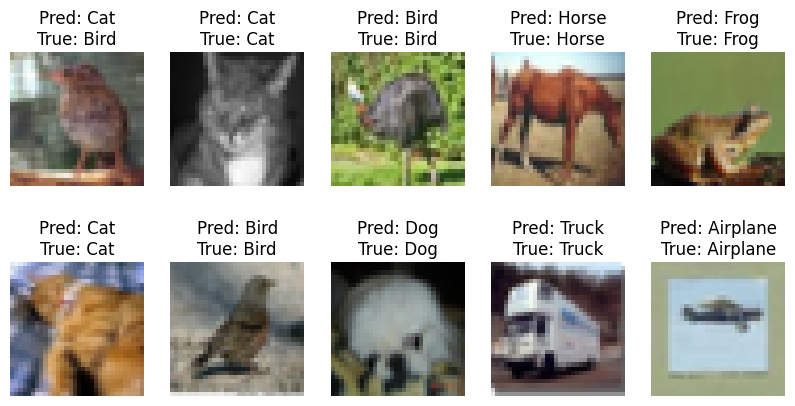

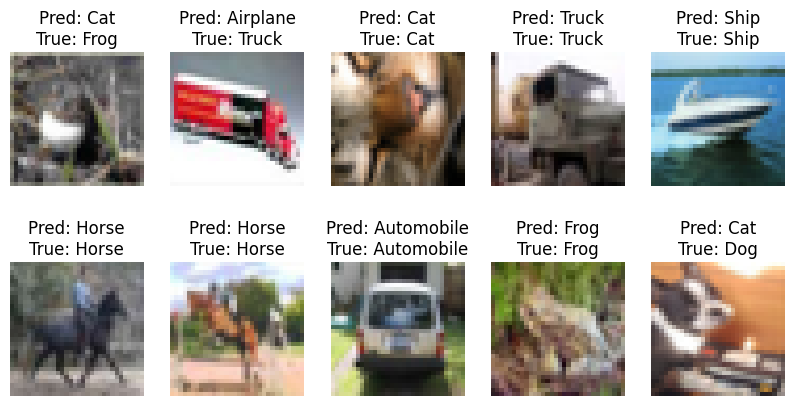

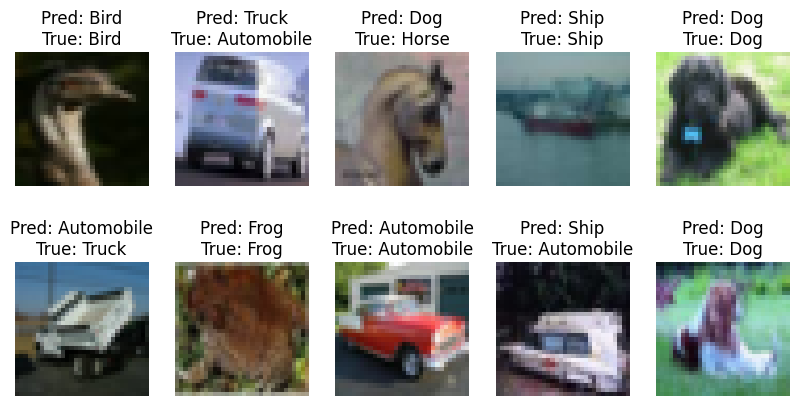

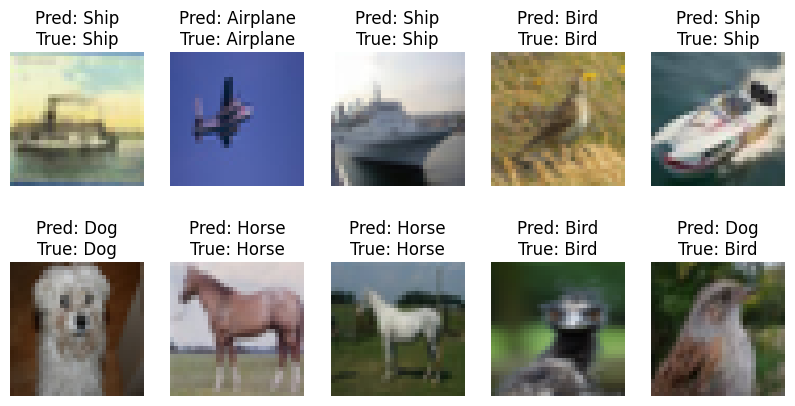

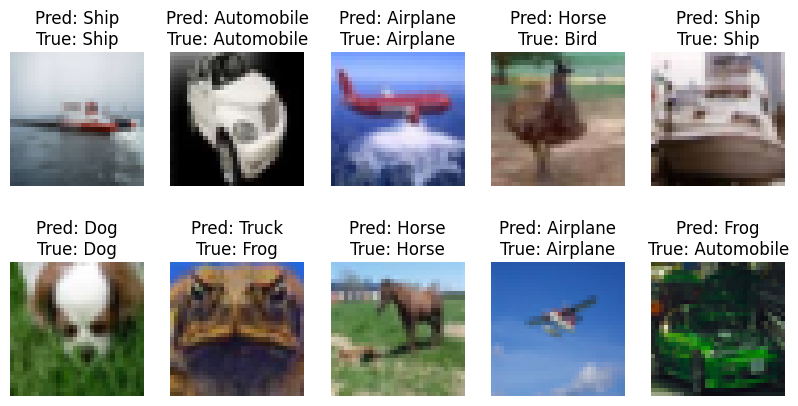

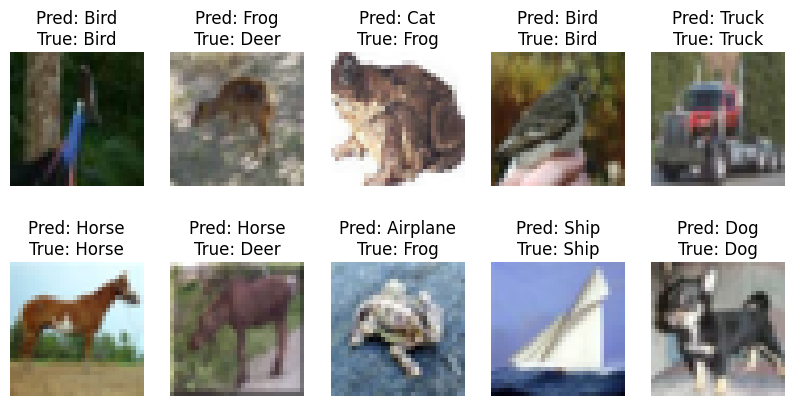

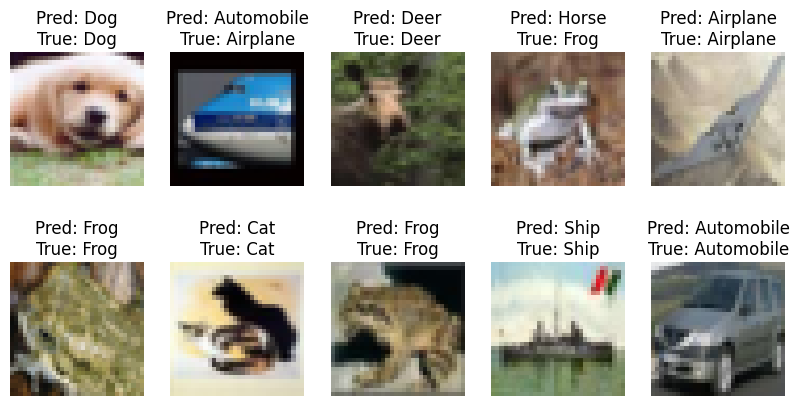

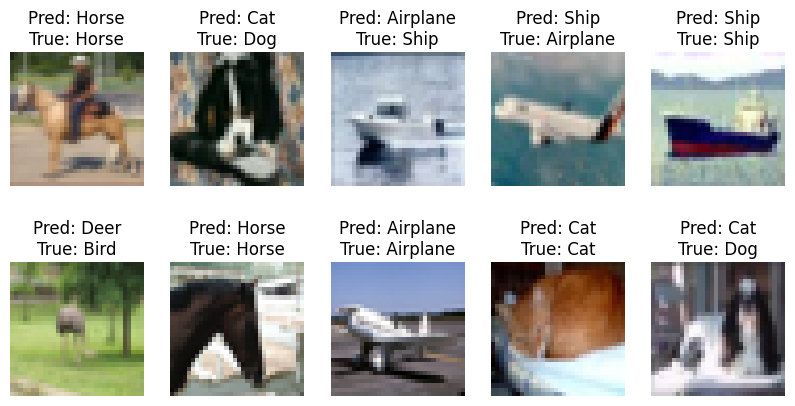

In [106]:
import matplotlib.pyplot as plt
import numpy as np

# Function to display images with predicted labels
def show_predictions(model, dataloader, device, num_images=10):
    model.eval()  # Set to evaluation mode
    for images,labels in dataloader:
    # images, labels = next(iter(dataloader))  # Get a batch
      images, labels = images.to(device), labels.to(device)

      with torch.no_grad():  # Disable gradient computation
          outputs = model(images)
          predictions = outputs.argmax(dim=1)  # Get predicted class

      # CIFAR-10 class names
      classes = ['Airplane', 'Automobile', 'Bird', 'Cat', 'Deer',
                'Dog', 'Frog', 'Horse', 'Ship', 'Truck']

      # Plot images with predictions
      fig, axes = plt.subplots(2, 5, figsize=(10, 5))
      for i, ax in enumerate(axes.flat[:num_images]):
          img = images[i]
          img = np.transpose(img.cpu().numpy(), (1, 2, 0))  # Convert to (H, W, C)

          ax.imshow(img)
          ax.set_title(f"Pred: {classes[predictions[i].item()]}\nTrue: {classes[labels[i].item()]}")
          ax.axis("off")

      plt.show()

# Show predictions
show_predictions(model, testloader, device)
